Check how many sites can have a better mutation; And the number of total positive mutation

In [ ]:
import pandas as pd

# load your mutation results
df = pd.read_csv("/home/eva/0_point_mutation/results/antifold/vhh_antifold.csv", sep="\t")

summary = []

for sample in df["sample"].unique():
    subset = df[df["sample"] == sample]
    positive = subset[subset["delta_log_likelihood"] > 0]
    
    n_positions_with_positive_delta = positive[["chain", "pos"]].drop_duplicates().shape[0]
    n_total_positive_mutations = positive.shape[0]
    
    best_per_position = (
        positive
        .groupby(["chain", "pos"])
        ["delta_log_likelihood"]
        .max()
        .mean()
    )
    
    summary.append({
        "sample": sample,
        "n_positions_with_positive_delta": n_positions_with_positive_delta,
        "n_total_positive_mutations": n_total_positive_mutations,
        "mean_best_positive_delta": best_per_position
    })

summary_df = pd.DataFrame(summary)
summary_df.to_csv("/home/eva/0_point_mutation/results/mab_summary.csv", sep="\t", index=False)
print("Wrote mab_summary.csv with summary statistics.")


Wrote mab_summary.csv with summary statistics.


KeyError: 'chain'

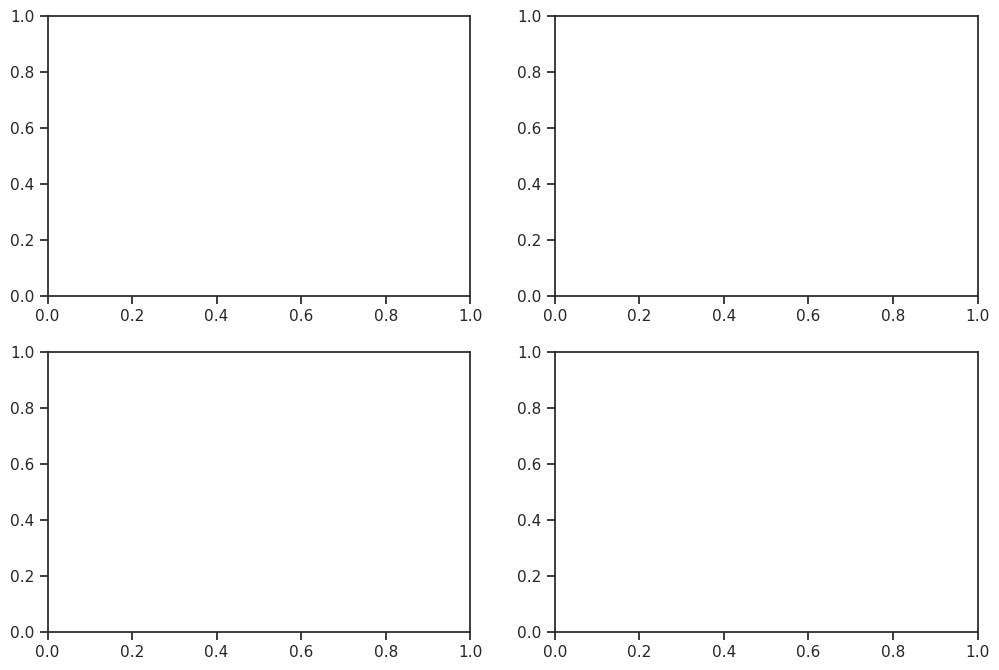

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# load your results
df = pd.read_csv("/home/eva/0_point_mutation/results/mab_summary.csv", sep="\t")

# sites of interest
sites = [('VH', 'H103'), ('VH', 'H104'), ('VH', 'H68')]

sns.set_theme(style="ticks")

n_sites = len(sites)
ncols = 2
nrows = (n_sites + ncols - 1) // ncols

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, nrows * 4))
axes = axes.flatten()

for ax, (chain, pos) in zip(axes, sites):
    site_df = df[(df["chain"] == chain) & (df["imgt_pos"] == pos)]
    if site_df.empty:
        ax.set_title(f"{chain} {pos} (no data)")
        continue

    # violin
    sns.violinplot(
        data=site_df,
        x="mt",
        y="mut_log_likelihood",
        palette="vlag",
        inner=None,
        scale="width",
        cut=0,
        ax=ax
    )

    # scatter on top
    sns.stripplot(
        data=site_df,
        x="mt",
        y="mut_log_likelihood",
        color="k",
        size=1,
        alpha=0.8,
        jitter=True,
        ax=ax
    )

    ax.axhline(0, linestyle="--", color="gray")
    ax.set_title(f"{chain} position {pos} mutation scan")
    ax.set_xlabel("Mutant amino acid")
    ax.set_ylabel("mut_log_likelihood")

sns.despine()
plt.tight_layout()
plt.savefig("multi_site_mutscan_violin.png", dpi=300)
plt.close()
print("Wrote multi_site_mutscan_violin.png")


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

# load results
df = pd.read_csv("/home/eva/0_point_mutation/results/antifold/vhh_antifold.csv", sep="\t")
df['mut_log_likelihood'].isna()

0          False
1          False
2          False
3          False
4          False
           ...  
4177848    False
4177849    False
4177850    False
4177851    False
4177852    False
Name: mut_log_likelihood, Length: 4177853, dtype: bool

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import re

# Load
df = pd.read_csv("/home/eva/0_point_mutation/results/antifold/vhh_antifold.csv", sep="\t")

print("Columns in dataframe:", df.columns.tolist())

sns.set_theme(style="ticks")

unique_sites = df[["chain", "kabat_pos"]].drop_duplicates()

# extract real chain and number
def parse_site(row):
    kabat_pos = str(row["kabat_pos"])
    chain_orig = str(row["chain"]).upper()
    # extract chain from kabat_pos, e.g. H100A
    m = re.match(r"([HL])(\d+)([A-Za-z]?)", kabat_pos)
    if m:
        chain_code = m.group(1)
        pos_num = int(m.group(2))
        pos_letter = m.group(3) or ""
        return chain_code, pos_num, pos_letter
    else:
        # fallback
        return "pos", 0, ""
    
def sort_key(row):
    chain_code, pos_num, pos_letter = parse_site(row)
    if chain_code == "H":
        return (0, pos_num, pos_letter)
    elif chain_code == "L":
        return (1, pos_num, pos_letter)
    elif chain_code == "pos":
        return (2, 0, "")
    else:
        return (3, pos_num, pos_letter)

# sort
unique_sites_sorted = unique_sites.copy()
unique_sites_sorted["sort_order"] = unique_sites_sorted.apply(sort_key, axis=1)
unique_sites_sorted = unique_sites_sorted.sort_values(by="sort_order")

# check order
print("Final plotting order:")
print(unique_sites_sorted[["chain", "kabat_pos"]])

# plotting
with PdfPages("all_sites_mutscan_antifold.pdf") as pdf:
    for _, row in unique_sites_sorted.iterrows():
        chain = row["chain"]
        pos = row["kabat_pos"]
        site_df = df[(df["chain"] == chain) & (df["kabat_pos"] == pos)]
        
        plt.figure(figsize=(7, 5))
        
        if site_df.empty or "mut_log_likelihood" not in site_df.columns:
            plt.title(f"{chain} {pos} (no data or missing column)")
            pdf.savefig()
            plt.close()
            continue
        
        sns.violinplot(
            data=site_df,
            x="mt",
            y="mut_log_likelihood",
            palette="vlag",
            inner=None,
            scale="width",
            cut=0
        )
        sns.stripplot(
            data=site_df,
            x="mt",
            y="mut_log_likelihood",
            color="k",
            alpha=0.5,
            size=2,
            jitter=True
        )
        
        plt.axhline(0, linestyle="--", color="gray")
        plt.title(f"{chain} position {pos}", fontsize=12)
        plt.xlabel("Mutant amino acid")
        plt.ylabel("mut_log_likelihood")
        sns.despine()
        plt.tight_layout()
        pdf.savefig()
        plt.close()

print(f"Wrote all_sites_mutscan.pdf with {len(unique_sites_sorted)} pages")


/tmp/ipykernel_42856/3690772326.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Columns in dataframe: ['chain', 'pos', 'wt', 'mt', 'delta_log_likelihood', 'mut_log_likelihood', 'wt_log_likelihood', 'kabat_pos', 'mutation_label', 'sample']
Final plotting order:
        chain kabat_pos
0          VH        H1
19         VH        H2
38         VH        H3
57         VH        H4
76         VH        H5
...       ...       ...
4104       VL      L105
4123       VL      L106
1118207    VL      L107
607183     VH       NaN
4160886    VL       NaN

[281 rows x 2 columns]


/tmp/ipykernel_42856/3690772326.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/tmp/ipykernel_42856/3690772326.py:66: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(
/tmp/ipykernel_42856/3690772326.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/tmp/ipykernel_42856/3690772326.py:66: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(
/tmp/ipykernel_42856/3690772326.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed 

Wrote all_sites_mutscan.pdf with 281 pages


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob

# collect all CSVs
files = glob.glob('csv_folder/*.csv')

dfs = []
for file in files:
    df = pd.read_csv(file)
    # get model name from 5th column header
    modelname = df.columns[4].split('_')[-1]
    df['model'] = modelname
    dfs.append(df)

data = pd.concat(dfs, ignore_index=True)

# melt to unify the delta columns
delta_cols = [col for col in data.columns if col.startswith("delta_log_likelihood")]
melted = data.melt(
    id_vars=['chain', 'pos', 'wt', 'mt', 'sample', 'model'],
    value_vars=delta_cols,
    var_name='delta_type',
    value_name='delta_value'
)

# keep only rows where delta_type matches the current model
melted = melted[melted.apply(lambda x: x['delta_type'].endswith(x['model']), axis=1)]

# one facet plot per sample
for sample_name, df_sample in melted.groupby("sample"):
    g = sns.FacetGrid(
        df_sample, 
        col="model", 
        col_wrap=2,
        height=5,
        sharey=False
    )

    def scatter_with_cutoff(data, color, **kwargs):
        plt.axhline(0, linestyle="--", color="gray")  # zero reference line
        sns.scatterplot(
            data=data,
            x="pos",
            y="delta_value",
            color=color,
            alpha=0.7,
            **kwargs
        )
        # annotate top 3 best deltas per site
        for pos in data["pos"].unique():
            site_df = data[data["pos"] == pos]
            top3 = site_df.nsmallest(3, "delta_value")
            for _, row in top3.iterrows():
                plt.text(
                    row["pos"] + 0.1,
                    row["delta_value"],
                    row["mt"],
                    fontsize=8,
                    color=color,
                    fontweight="bold"
                )

    g.map_dataframe(scatter_with_cutoff)
    g.set_axis_labels("Position", "Delta log likelihood")
    g.set_titles("{col_name}")
    g.fig.suptitle(sample_name, fontsize=16)
    plt.tight_layout()
    plt.savefig(f"{sample_name}_facet.png", dpi=300)
    plt.close()


A pipeline to extract delta > 0 for all models and calclate rmsd

Step 1: Identify consensus-bad mutations

In [ ]:
import pandas as pd
import glob

files = glob.glob('csv_folder/*.csv')
dfs = []

for file in files:
    df = pd.read_csv(file)
    modelname = df.columns[4].split('_')[-1]
    df['model'] = modelname
    dfs.append(df)

data = pd.concat(dfs, ignore_index=True)

# pick all delta columns
delta_cols = [c for c in data.columns if c.startswith("delta_log_likelihood")]

# for each mutation, pivot to one row with its deltas
# assumes same sample
pivoted = data.pivot_table(
    index=["chain","pos","wt","mt","sample"],
    columns="model",
    values=delta_cols
)

# define “consensus bad” as delta>0 across ALL models
def all_models_bad(row):
    return all(val > 0 for val in row)

bad_mutations = pivoted.apply(all_models_bad, axis=1)
consensus_bad = pivoted[bad_mutations].reset_index()

# output for next step
consensus_bad.to_csv("consensus_bad_mutations.csv", index=False)


Step 2: Generate mutated FASTA sequences

In [ ]:
from Bio import SeqIO

# load your wildtype nanobody FASTA
wt_record = SeqIO.read("wildtype.fasta", "fasta")
wt_seq = list(str(wt_record.seq))

# load consensus bad mutations
consensus = pd.read_csv("consensus_bad_mutations.csv")

for _, row in consensus.iterrows():
    pos = int(row["pos"]) - 1  # assuming 1-indexed
    mt = row["mt"]
    mut_seq = wt_seq.copy()
    mut_seq[pos] = mt
    mut_str = "".join(mut_seq)

    outname = f"{row['sample']}_pos{row['pos']}_{row['wt']}to{mt}.fasta"
    SeqIO.write(
        SeqIO.SeqRecord(
            SeqIO.Seq(mut_str),
            id=outname.replace(".fasta",""),
            description=""
        ),
        outname,
        "fasta"
    )


Step 3: Run ABodyBuilder2

In [ ]:
abodybuilder2 --fasta your_mutated.fasta --outdir predictions/

Step 4: Calculate RMSD

In [ ]:
import pymol2
import pandas as pd
import glob

wt_pdb = "wildtype.pdb"

rmsd_results = []

with pymol2.PyMOL() as pymol:
    pymol.cmd.load(wt_pdb, "wt")

    for pdb in glob.glob("predictions/*.pdb"):
        name = pdb.split("/")[-1].replace(".pdb","")
        pymol.cmd.load(pdb, name)
        # align and get RMSD
        alignment = pymol.cmd.align(name, "wt")
        rmsd = alignment[0]
        print(f"{name}: RMSD = {rmsd:.3f} Å")

        # parse out mutation details from the filename
        # assuming your prediction filenames are like sample_pos12_EtoK.pdb
        # you can adapt this if needed
        parts = name.split("_")
        sample = parts[0]
        pos = int(parts[1].replace("pos",""))
        mt = parts[2].split("to")[1]
        wt = parts[2].split("to")[0][-1]
        
        rmsd_results.append({
            "sample": sample,
            "pos": pos,
            "wt": wt,
            "mt": mt,
            "rmsd": rmsd
        })

# save to CSV
pd.DataFrame(rmsd_results).to_csv("rmsd_results.csv", index=False)
